### KNN Classifier

## iris Dataset

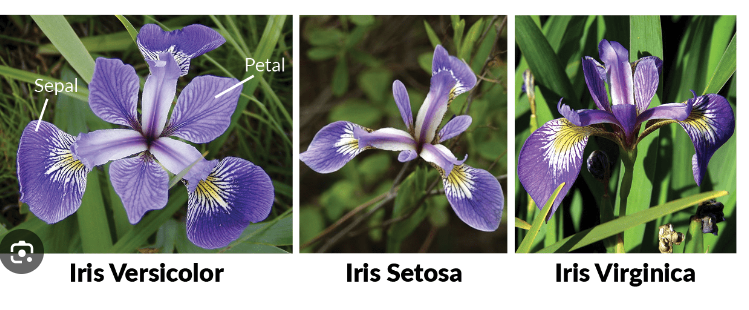

In [2]:
from warnings import filterwarnings
filterwarnings('ignore')

In [3]:
import pandas as pd
df = pd.read_csv('iris.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [5]:
df.isna().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

### Separate X and Y

In [6]:
X = df.drop(labels='species',axis=1)
Y = df[['species']]

In [7]:
X.head()

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
Y.value_counts().sum()

150

### Apply label encoder

In [9]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
Y['species'] = le.fit_transform(Y['species'])

In [10]:
Y

,species
0,0
1,0
2,0
3,0
4,0
...,...
145,2
146,2
147,2
148,2


### Preprocess X features

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

In [12]:
num_pipe = Pipeline(steps=[('imputer',SimpleImputer(strategy='mean')),
                           ('scaler',StandardScaler())])

In [13]:
X_pre = num_pipe.fit_transform(X)

In [14]:
X_pre[0:5]

array([[-0.90068117,  1.01900435, -1.34022653, -1.3154443 ],
       [-1.14301691, -0.13197948, -1.34022653, -1.3154443 ],
       [-1.38535265,  0.32841405, -1.39706395, -1.3154443 ],
       [-1.50652052,  0.09821729, -1.2833891 , -1.3154443 ],
       [-1.02184904,  1.24920112, -1.34022653, -1.3154443 ]])

In [15]:
cols = num_pipe.get_feature_names_out()
cols

array(['sepal_length', 'sepal_width', 'petal_length', 'petal_width'],
      dtype=object)

In [16]:
X_pre = pd.DataFrame(X_pre,columns=cols)
X_pre.head()

,sepal_length,sepal_width,petal_length,petal_width
0,-0.900681,1.019004,-1.340227,-1.315444
1,-1.143017,-0.131979,-1.340227,-1.315444
2,-1.385353,0.328414,-1.397064,-1.315444
3,-1.506521,0.098217,-1.283389,-1.315444
4,-1.021849,1.249201,-1.340227,-1.315444


## Train Test Split

In [17]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(X_pre,Y,test_size=0.33,random_state=42)

In [18]:
xtrain.shape

(100, 4)

In [19]:
xtest.shape

(50, 4)

## KNN model

In [20]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=15)
model.fit(xtrain,ytrain)

KNeighborsClassifier(n_neighbors=15)

In [21]:
model.score(xtrain,ytrain)

0.94

In [22]:
model.score(xtest,ytest)

0.96

### Tune the model with GSCV

In [23]:
params = {
    'n_neighbors': [2,3,4,5,6,7,8,9]
}

In [24]:
from sklearn.model_selection import GridSearchCV
KNN = KNeighborsClassifier()
GSCV = GridSearchCV(KNN, param_grid=params,cv=5,scoring='f1_macro')
GSCV.fit(xtrain,ytrain)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9]},
             scoring='f1_macro')

In [25]:
GSCV.best_score_

0.9319552669552669

In [26]:
GSCV.best_params_

{'n_neighbors': 3}

In [27]:
GSCV.best_score_

0.9319552669552669

In [28]:
best_KNN = GSCV.best_estimator_
best_KNN

KNeighborsClassifier(n_neighbors=3)

### Evaluate the model

In [29]:
best_KNN.score(xtrain,ytrain)

0.95

In [30]:
best_KNN.score(xtest,ytest)

0.98

### Check ConfusionMatrix

In [31]:
ypred_tr = best_KNN.predict(xtrain)
ypred_ts = best_KNN.predict(xtest)

In [32]:
ypred_ts[0:5]

array([1, 0, 2, 1, 1])

In [33]:
ytest.head()

,species
73,1
18,0
118,2
78,1
76,1


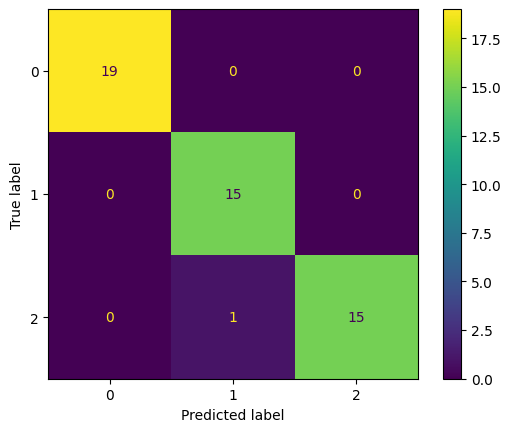

In [34]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cf = confusion_matrix(ytest,ypred_ts)
cfd = ConfusionMatrixDisplay(cf, display_labels=best_KNN.classes_)
cfd.plot()

### Print Classification Report

In [35]:
from sklearn.metrics import classification_report
print(classification_report(ytest,ypred_ts))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       0.94      1.00      0.97        15
           2       1.00      0.94      0.97        16

    accuracy                           0.98        50
   macro avg       0.98      0.98      0.98        50
weighted avg       0.98      0.98      0.98        50



### Getting the original labels

In [36]:
ypred_tr_lb = le.inverse_transform(ypred_tr)
ypred_ts_lb = le.inverse_transform(ypred_ts)

In [37]:
ypred_tr_lb

array(['versicolor', 'virginica', 'versicolor', 'setosa', 'virginica',
       'versicolor', 'setosa', 'setosa', 'setosa', 'versicolor',
       'virginica', 'setosa', 'setosa', 'setosa', 'versicolor', 'setosa',
       'versicolor', 'virginica', 'setosa', 'versicolor', 'virginica',
       'setosa', 'virginica', 'virginica', 'versicolor', 'versicolor',
       'virginica', 'versicolor', 'setosa', 'versicolor', 'virginica',
       'setosa', 'setosa', 'versicolor', 'versicolor', 'setosa',
       'virginica', 'setosa', 'setosa', 'virginica', 'versicolor',
       'virginica', 'virginica', 'versicolor', 'virginica', 'versicolor',
       'setosa', 'setosa', 'versicolor', 'virginica', 'setosa', 'setosa',
       'setosa', 'versicolor', 'virginica', 'setosa', 'virginica',
       'virginica', 'setosa', 'versicolor', 'versicolor', 'virginica',
       'versicolor', 'virginica', 'setosa', 'virginica', 'versicolor',
       'virginica', 'versicolor', 'versicolor', 'versicolor', 'setosa',
       'versicol

In [38]:
ypred_ts_lb

array(['versicolor', 'setosa', 'virginica', 'versicolor', 'versicolor',
       'setosa', 'versicolor', 'virginica', 'versicolor', 'versicolor',
       'virginica', 'setosa', 'setosa', 'setosa', 'setosa', 'versicolor',
       'virginica', 'versicolor', 'versicolor', 'virginica', 'setosa',
       'virginica', 'setosa', 'virginica', 'virginica', 'virginica',
       'virginica', 'virginica', 'setosa', 'setosa', 'setosa', 'setosa',
       'versicolor', 'setosa', 'setosa', 'virginica', 'versicolor',
       'setosa', 'setosa', 'setosa', 'virginica', 'versicolor',
       'versicolor', 'setosa', 'setosa', 'versicolor', 'versicolor',
       'virginica', 'versicolor', 'virginica'], dtype=object)

In [39]:
best_KNN.predict_proba(xtest)

array([[0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.66666667, 0.33333333],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.66666667, 0.33333333],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.

### Predicting New Species

In [42]:
def predict_data():
    # Taking input from user
    sep_len = float(input('Sepal Length : '))
    sep_wid = float(input('Sepal Width : '))
    pet_len = float(input('Petal Length : '))
    pet_wid = float(input('Petal Width : '))

    # Converting input to Dataframe
    xnew = pd.DataFrame([sep_len, sep_wid, pet_len, pet_wid]).T
    xnew.columns = ['sepal_length','sepal_width','petal_length','petal_width']

    # Display Dataframe
    print('Dataframe before preprocessing :\n')
    display(xnew)

    # Preprocess the dataframe
    xnew_pre = num_pipe.transform(xnew)
    xnew_pre = pd.DataFrame(xnew_pre,columns=cols)

    # Display the dataframe
    print('\nDataframe after Preprocessing : \n')
    display(xnew_pre)

    # Predict the data
    pred = best_KNN.predict(xnew_pre)

    # Label encoder to get orignal speices
    pred_lb = le.inverse_transform(pred)[0]

    # Get the proba
    prob = best_KNN.predict_proba(xnew_pre).max()

    # Print the results
    print('\n====================================================\n')
    print(f'Predicted Species : {pred_lb} with Probability : {prob:.4f}')

    return pred_lb, prob  




In [44]:
predict_data()

Dataframe before preprocessing :



,sepal_length,sepal_width,petal_length,petal_width
0,6.4,2.9,4.3,1.3



Dataframe after Preprocessing : 



,sepal_length,sepal_width,petal_length,petal_width
0,0.674501,-0.362176,0.308059,0.13251




Predicted Species : versicolor with Probability : 1.0000


('versicolor', 1.0)

In [45]:
predict_data()

Dataframe before preprocessing :



,sepal_length,sepal_width,petal_length,petal_width
0,5.0,3.6,1.4,0.2



Dataframe after Preprocessing : 



,sepal_length,sepal_width,petal_length,petal_width
0,-1.021849,1.249201,-1.340227,-1.315444




Predicted Species : setosa with Probability : 1.0000


('setosa', 1.0)